In [11]:
from data.data_preparing import DataPreprocessing
from models.deepMF import DMF, DMFLoss
from metrics.model_metrics import Metrics
from data.uploading import UploadData
from negentropy_approximations.approximations import NegentropyApprox5

from typing import List, Callable
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam
from itertools import chain
import matplotlib.pyplot as plt

In [12]:
metrics_names = ['RMSE', 'NDCG', 'USpars', 'ISpars', 'UCorr', 'ICorr', 'UNegsumDiff', 'INegsumDiff']

df_columns = ['Epoch'] + list(chain.from_iterable(('Train '+i, 'Valid '+ i) for i in metrics_names))

PATH_TO_SAVING_MODELS = "/home/aleksandra/MainInfo/magistr/diploma/diploma_recSys/data/datasets"

In [13]:
def construct_deepMF_model_configs(users_count: int, items_count: int, latent_factor_size: int, hidden_outputs: List[int], learning_rate: float):
  configs = {'users_count' : users_count,
           'items_count': items_count,
           'latent_factor_size' : latent_factor_size,
           'hidden_outputs' : hidden_outputs,
           'learning_rate' : learning_rate}
  return configs

def construct_metric_configs(k_top: int, sparsity_decimals: int, indep_decimals: int, negentropy_approx: Callable):
    configs = {"k_top" : k_top,
               "sparsity_decimals": sparsity_decimals,
               "indep_decimals" : indep_decimals,
               "negentropy_approx" : negentropy_approx}
    return configs

def construct_data(df: pd.DataFrame, data_preprocessor: DataPreprocessing, batch_size: int, per: float = 0.2):
    train_dl, test_dl = data_preprocessor.get_train_test_dataloader(df, batch_size, per)
    train_ds, test_ds = data_preprocessor.get_train_test_grouped_by_user(df, per)

    return [train_dl, train_ds, test_dl, test_ds]

In [14]:
def calculate_model_metrics(model, ds, metrics, device):
    with torch.no_grad():
      #-----------------------------------------------
      total_rmse = 0
      total_ndcg = 0
      total_spars_u = 0
      total_spars_i = 0
      total_corr_i = 0
      total_neg_sum_diff_i = 0

      users_count = len(ds)
      total_cou = 0

      users_v = []

      for batch, (u, i, r, u_v, i_v) in enumerate(ds):
        r, u_v, i_v = r.to(device), u_v.to(device), i_v.to(device)
        epoch_r, epoch_u, epoch_i = model(u_v, i_v)
        users_v.append(epoch_u[0].numpy())
        cou = u.shape[0]
        total_cou += cou
        _, mse, ndcg = metrics.accurasy(r, epoch_r.squeeze())
        total_rmse += cou*mse
        total_ndcg += ndcg
        total_spars_u += cou*metrics.sparsity(epoch_u)
        total_spars_i += cou*metrics.sparsity(epoch_i)
        corr_i, neg_sum_i = metrics.independence(epoch_i)
        total_corr_i += corr_i
        total_neg_sum_diff_i += neg_sum_i

      users_v = torch.from_numpy(np.array(users_v))

      total_rmse = (total_rmse/total_cou)**(1/2)
      total_ndcg = total_ndcg/users_count

      total_spars_u = total_spars_u/total_cou
      total_spars_i = total_spars_i/total_cou

      total_corr_u, total_neg_sum_diff_u =  metrics.independence(users_v)

      total_corr_i = total_corr_i/users_count
      total_neg_sum_diff_i = total_neg_sum_diff_i/users_count

    return total_rmse, total_ndcg, total_spars_u, total_spars_i,\
           total_corr_u, total_corr_i, total_neg_sum_diff_u, total_neg_sum_diff_i

In [30]:
def fit_deepMF_model(epoch_count: int, data, model_configs, metric_configs, max_rate: float = 5.0, save_name : str = "deepMF_classic"):

    train_dl, train_pers, test_dl, test_pers = data

    learning_rate = model_configs['learning_rate']
    users_count = model_configs['users_count']
    items_count = model_configs['items_count']
    latent_factor_size = model_configs['latent_factor_size']
    hidden_outputs = model_configs['hidden_outputs']

    k_top = metric_configs['k_top']
    sparsity_decimals = metric_configs['sparsity_decimals']
    indep_decimals = metric_configs['indep_decimals']
    negEntropy_approx = metric_configs['negentropy_approx']

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Подключились к {device}")

    model = DMF(items_count, users_count, latent_factor_size, hidden_outputs)
    model = model.to(device)
    # TODO: для обучения с добавлением ограничений нужно заменить данную функцию потерь
    loss_func = DMFLoss(max_rate)

    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-06)
    metrics = Metrics(negEntropy_approx, k_top, sparsity_decimals, indep_decimals)

    results = []

    best_test_ndcg = 0
    best_test_epoch = -1

    for epoch in range(epoch_count):
        print(f"epoch {epoch}")

        for batch, (u, i, r, u_v, i_v) in enumerate(train_dl):
            r, u_v, i_v = r.to(device), u_v.to(device), i_v.to(device)
            r_lf, u_lf, i_lf = model(u_v, i_v)
            # TODO: при использовании лосс-функций с добавлением ограничений необходимо добавить необходимые для вызова аргументы
            loss = loss_func(r, torch.squeeze(r_lf))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tr_rmse, tr_ndcg, tr_spars_u, tr_spars_i, tr_corr_u, tr_corr_i, tr_neg_sum_diff_u, tr_neg_sum_diff_i = calculate_model_metrics(model, train_pers, metrics, device)

        test_rmse, test_ndcg, test_spars_u, test_spars_i, test_corr_u, test_corr_i, test_neg_sum_diff_u, test_neg_sum_diff_i = calculate_model_metrics(model, test_pers, metrics, device)

        if best_test_ndcg < test_ndcg:
            best_test_epoch = epoch
            best_test_ndcg = test_ndcg
            torch.save(model.state_dict(), f"{PATH_TO_SAVING_MODELS}/{save_name}_best_test.pth")

        results.append([epoch, tr_rmse, test_rmse, tr_ndcg, test_ndcg, tr_spars_u, test_spars_u, tr_spars_i, test_spars_i, tr_corr_u, test_corr_u, tr_corr_i, test_corr_i, tr_neg_sum_diff_u, test_neg_sum_diff_u, tr_neg_sum_diff_i, test_neg_sum_diff_i])

    torch.save(model.state_dict(), f"{PATH_TO_SAVING_MODELS}/{save_name}_last_step.pth")

    print("-------Train ended---------")
    print(f"best test epoch = {best_test_epoch}")
    results_df = pd.DataFrame(results, columns = df_columns)
    return model, results_df

In [24]:
def test_model(data, model_configs, model_name, metric_configs):
    _, train_pers, _, test_pers = data

    learning_rate = model_configs['learning_rate']
    users_count = model_configs['users_count']
    items_count = model_configs['items_count']
    latent_factor_size = model_configs['latent_factor_size']
    hidden_outputs = model_configs['hidden_outputs']

    k_top = metric_configs['k_top']
    sparsity_decimals = metric_configs['sparsity_decimals']
    indep_decimals = metric_configs['indep_decimals']
    negEntropy_approx = metric_configs['negentropy_approx']

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Подключились к {device}")

    model_dict = torch.load(f"{PATH_TO_SAVING_MODELS}/{model_name}_best_test.pth", map_location=torch.device(device))

    model = DMF(items_count, users_count, latent_factor_size, hidden_outputs)
    model.load_state_dict(model_dict)
    model = model.to(device)

    metrics = Metrics(negEntropy_approx, k_top, sparsity_decimals, indep_decimals)

    model.eval()
    with torch.no_grad():
        tr_rmse, tr_ndcg, tr_spars_u, tr_spars_i, tr_corr_u, tr_corr_i, tr_neg_sum_diff_u, tr_neg_sum_diff_i = calculate_model_metrics(model, train_pers, metrics, device)

        test_rmse, test_ndcg, test_spars_u, test_spars_i, test_corr_u, test_corr_i, test_neg_sum_diff_u, test_neg_sum_diff_i = calculate_model_metrics(model, test_pers, metrics, device)

    results = []
    results.append([tr_rmse, tr_ndcg, tr_spars_u, tr_spars_i, tr_corr_u, tr_corr_i, tr_neg_sum_diff_u, tr_neg_sum_diff_i])
    results.append([test_rmse, test_ndcg, test_spars_u, test_spars_i, test_corr_u, test_corr_i, test_neg_sum_diff_u, test_neg_sum_diff_i])

    df = pd.DataFrame(results, columns = metrics_names, index=['train', 'test'])

    return df

In [29]:
def plot_epochs_metric(epochs_count: int, train_res: List[float], valid_res: List[float], metric_name: str):
    epochs = [i for i in range(epochs_count)]
    plt.plot(epochs, train_res, color='r', label='train')
    plt.plot(epochs, valid_res, color='g', label='test')

    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.title(metric_name)

    plt.legend()
    plt.show()

# Исполняемый код:

In [18]:
movilens_ratings = UploadData.movielens_100k_df()
movilens_ratings

,UserId,MovieId,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [19]:
movielens_preprocessor = DataPreprocessing("UserId", "MovieId", "Rating", "Timestamp", 1, 5)
users_count =movilens_ratings['UserId'].nunique()
items_count = movilens_ratings['MovieId'].nunique()
batch_size = 1024

data = construct_data(movilens_ratings, movielens_preprocessor, batch_size)

model_configs = construct_deepMF_model_configs(users_count, items_count, latent_factor_size = 20, hidden_outputs = [20*10, 20*5],  learning_rate = 0.001)

metric_configs = construct_metric_configs(10, 1, 5, NegentropyApprox5())

In [26]:
model, df = fit_deepMF_model(50, data, model_configs, metric_configs, 5, "deepMF_100k_200_100_20")

Подключились к cpu
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
-------Train ended---------
best test epoch = 11


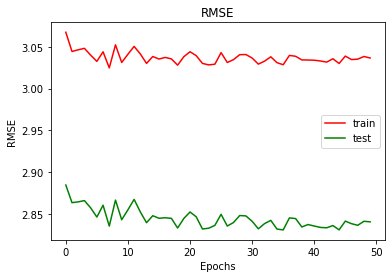

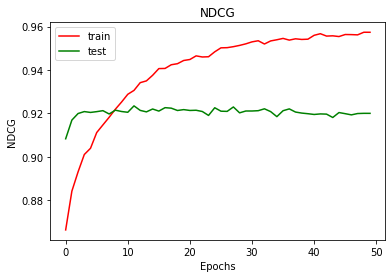

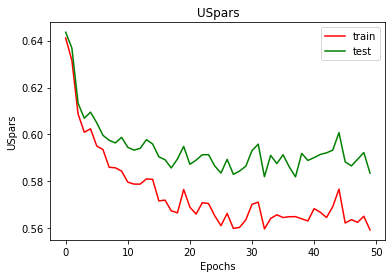

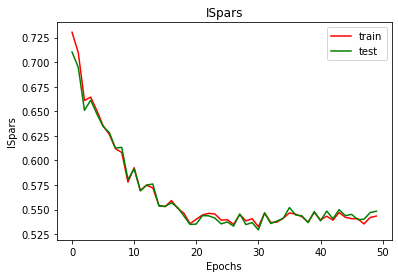

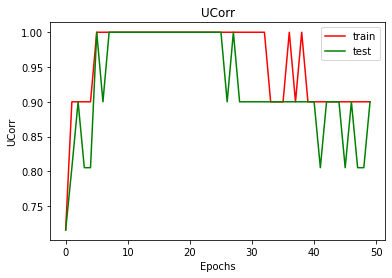

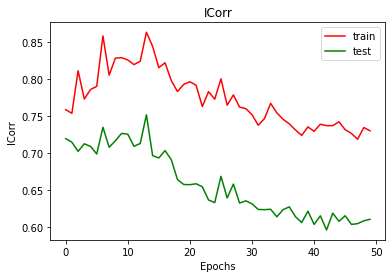

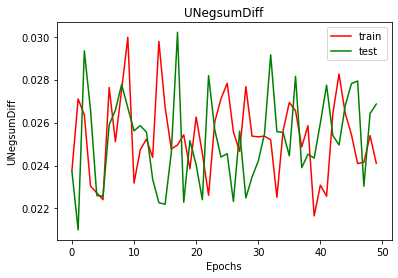

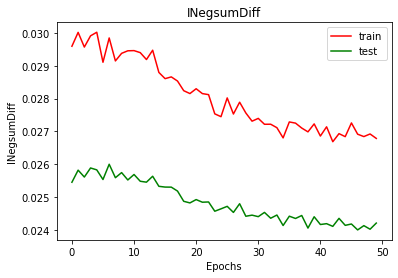

In [27]:
epoch_count = df.shape[0]
for m in metrics_names:
  plot_epochs_metric(epoch_count, df['Train '+m].to_list(), df['Valid '+m].to_list(), m)

In [28]:
test_model(data, model_configs, "deepMF_100k_200_100_20", metric_configs)

Подключились к cpu


,RMSE,NDCG,USpars,ISpars,UCorr,ICorr,UNegsumDiff,INegsumDiff
train,3.050454,0.930610,tensor(0.5789),tensor(0.5694),tensor(1.),tensor(0.8198),tensor(0.0255),tensor(0.0294)
test,2.867571,0.923483,tensor(0.5933),tensor(0.5691),tensor(1.),tensor(0.7095),tensor(0.0225),tensor(0.0254)
